# Example of MCMC in Python

In [1]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import emcee as mc

Read data in

In [2]:
os.getcwd()

'C:\\LocalData\\aipentti\\OneDrive - University of Helsinki\\Kurssit\\Oma opetus\\Tähtitieteen inversiomenetelmät (ja data-analyysi)\\Moniste\\Jupyter notebooks'

In [3]:
data=pd.read_csv('dataRed.dat',sep='\t')
data

phase angle (deg)  polarization (%)
0                 3.10             -1.00
1                 5.25             -1.33
2                 6.90             -0.40
3                15.30             -1.10
4                15.30             -1.00
..                 ...               ...
164              48.60             16.01
165              48.75             15.61
166              49.07             13.40
167              49.07             16.00
168              49.07             17.59

[169 rows x 2 columns]

Show data

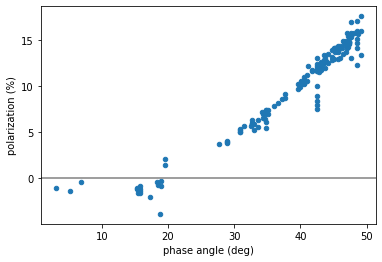

In [4]:
g=data.plot(x='phase angle (deg)',y='polarization (%)',kind='scatter')
g.axhline(0,color='gray')

Define function to be fitted

In [5]:
def f(x,b,c1,c2,a0):
    a=np.radians(x)
    return b * np.power(np.sin(a),c1) * np.power(np.cos(a/2),c2) * np.sin(a-np.radians(a0))

Show data and function, find approximate parameter values just by eye

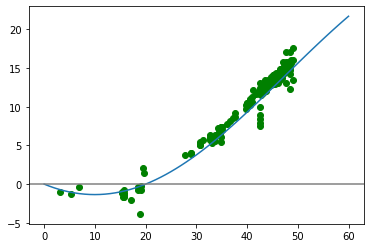

In [6]:
x=np.linspace(0,60,61)
y=f(x,45,1,1,20)
x2=data['phase angle (deg)']
y2=data['polarization (%)']
plt.plot(x,y)
plt.scatter(x2,y2,color='green')
plt.axhline(0,color='gray')

Start to fit, log-likelihood of the model

In [7]:
def log_likelihood(theta,data):
    b,c1,c2,a0,sig = theta
    n = len(data)
    sig2 = np.power(sig,2)
    Sv = data.apply(lambda x: (x[1] - f(x[0],b,c1,c2,a0))**2,axis=1)
    S = Sv.sum()
    return -n/2*np.log(2*np.pi*sig2) - S/(2*sig2)

Test direct minimization

In [8]:
nll = lambda *args: -log_likelihood(*args)
sol = minimize(nll,[45,1,1,20,1],args=(data))
sol

      fun: 223.5135169321595
 hess_inv: array([[ 8.35962575e+01,  1.61953373e+00,  1.28760917e+01,
         3.32976576e+00, -4.28763333e-03],
       [ 1.61953373e+00,  3.55674887e-02,  2.42801648e-01,
         4.01285452e-02, -4.50592808e-05],
       [ 1.28760917e+01,  2.42801648e-01,  2.02687817e+00,
         4.94886629e-01, -6.72660111e-04],
       [ 3.32976576e+00,  4.01285452e-02,  4.94886629e-01,
         3.94090427e-01, -4.51823434e-04],
       [-4.28763333e-03, -4.50592808e-05, -6.72660111e-04,
        -4.51823434e-04,  2.49374500e-03]])
      jac: array([ 1.90734863e-06, -9.53674316e-06, -5.72204590e-06, -3.81469727e-06,
        7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 150
      nit: 20
     njev: 25
   status: 0
  success: True
        x: array([48.57718967,  0.89997341,  1.57961418, 19.92147351,  0.90812492])

Plot fit

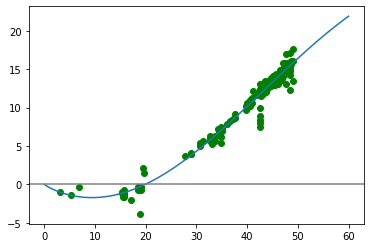

In [9]:
fb,fc1,fc2,fa0,fsig = sol.x
x=np.linspace(0,60,61)
y=f(x,fb,fc1,fc2,fa0)
x2=data['phase angle (deg)']
y2=data['polarization (%)']
plt.plot(x,y)
plt.scatter(x2,y2,color='green')
plt.axhline(0,color='gray')

Go to actual MCMC

Prior function, or rather the log prior.

In [10]:
def log_prior(theta):
    b,c1,c2,a0,sig = theta
    if 0 <= b <= 100 and 0 < c1 and 0 < c2 and 0 <= a0 <= 180 and 0 < sig:
        return 0.0
    return -np.inf

Combine log-likelihood and log-prior

In [11]:
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)

Finally, start MCMC. Initialize from random value around ML solution. Do 10 chains.

In [12]:
pos = sol.x + [3,0.1,0.1,3,0.1] * np.random.randn(10, 5)
nwalkers, ndim = pos.shape

Do sampler object

In [13]:
sampler = mc.EnsembleSampler(nwalkers, ndim, log_probability)

Run MCMC sampling

In [14]:
sampler.run_mcmc(pos,5000,progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:08<00:00, 16.19it/s]


Get data from chains

In [15]:
samples = sampler.get_chain()

Plot chains, only three to increase visibility

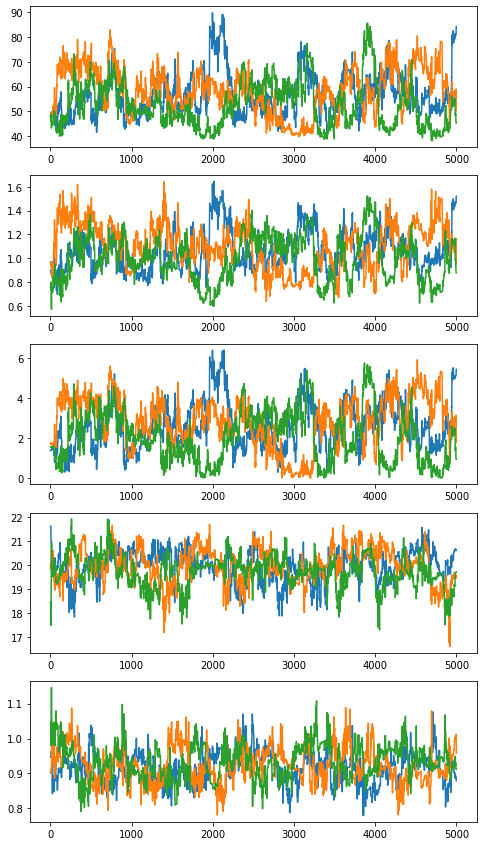

In [16]:
fig, axs = plt.subplots(5,figsize=[8,15])
axs[0].plot(samples[:,0:3,0])
axs[1].plot(samples[:,0:3,1])
axs[2].plot(samples[:,0:3,2])
axs[3].plot(samples[:,0:3,3])
axs[4].plot(samples[:,0:3,4])

Let's forget burn-in here and see full posterior distributions over all chains

(array([  209.,  1630.,  7371., 14443., 13743.,  8596.,  2970.,   833.,
          185.,    20.]),
 array([0.76662744, 0.80452279, 0.84241813, 0.88031348, 0.91820882,
        0.95610417, 0.99399952, 1.03189486, 1.06979021, 1.10768555,
        1.1455809 ]),
 <BarContainer object of 10 artists>)

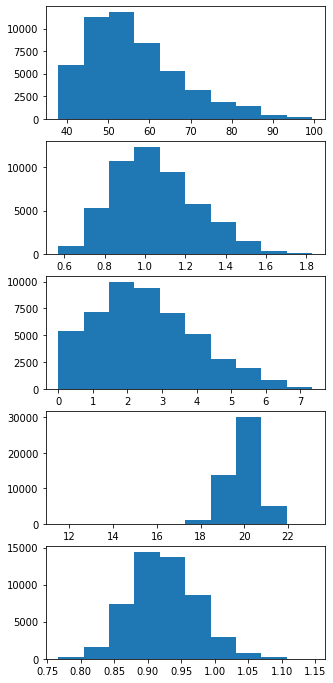

In [17]:
fig, axs = plt.subplots(5,figsize=[5,12])
axs[0].hist(samples[:,:,0].flatten())
axs[1].hist(samples[:,:,1].flatten())
axs[2].hist(samples[:,:,2].flatten())
axs[3].hist(samples[:,:,3].flatten())
axs[4].hist(samples[:,:,4].flatten())

Point-estimates as posterior means

In [18]:
bpe = []
for i in range(5):
    bpe.append(np.mean(samples[:,:,i].flatten()))
bpe

[56.37520191743268,
 1.0503864262348088,
 2.538147509649323,
 19.93596074984672,
 0.9243823377670042]

Plot MCMC fit

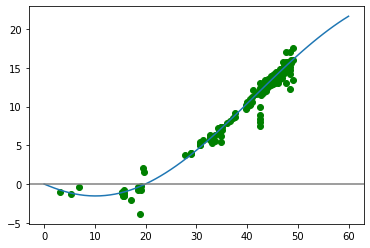

In [19]:
fb,fc1,fc2,fa0,fsig = bpe
x=np.linspace(0,60,61)
y=f(x,fb,fc1,fc2,fa0)
x2=data['phase angle (deg)']
y2=data['polarization (%)']
plt.plot(x,y)
plt.scatter(x2,y2,color='green')
plt.axhline(0,color='gray')